In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [68]:
data = pd.read_csv('../Data/data__raw_23_03_22.csv')

C:\Users\Joseph.Amess\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [69]:
#Keep only actual sales select planning period and remove uneeded cols
def drop_cols_and_rows(data, period_choice):
    data = data[data['FieldID'] == 'ACTSLS']
    data = data[data['PlanningPeriod'] == period_choice]
    return data


#Rename cols
def col_renamer(data, rename_dict):
    for col_name in list(rename_dict.keys()):
        data.rename(columns={col_name:rename_dict[col_name]}, inplace=True)
    return data


#Make artificial time index, timeseries and remove negative vols
def create_time_index(data):
    data['Date']= pd.to_datetime(data['Date'])
    data["Date"].dt.year * 12
    data["time_idx"] = data["Date"].dt.year * 12 + data["Date"].dt.month
    data["time_idx"] -= data["time_idx"].min()
    data["month"] = data.Date.dt.month.astype(str).astype("category")
    data = data.assign(
                        timeseries=pd.factorize(list(zip(
                        *[data[c].values.tolist() for c in ['ParentItemID', 'PlantID']] #removed plantID
                        )))[0] + 1
                        )
    data.Volume=data.Volume.mask(data.Volume.lt(0),0)
    return data


#Only use if want to remove final time index
def remove_last_time_idx(data):
    data = data[data['time_idx'] != 35]
    return data

In [70]:
RENAME_DICT = {'FieldContent':'Volume', 'PlannedPeriod':'Date'}
PLANNING_DATE = '2022-01-01'


def data_preprocessing(data, rename_dict, planning_date):
    print('Shape of data before:', data.shape)
    data = drop_cols_and_rows(data, planning_date)
    data = col_renamer(data, rename_dict)
    data = create_time_index(data)
    data = remove_last_time_idx(data)
    print('')
    print('Shape of data after:', data.shape)
    print('Number of timeseries:', int(data.shape[0] / 35))
    return data


data_processed = data_preprocessing(data, RENAME_DICT, PLANNING_DATE)

Shape of data before: (2906736, 13)

Shape of data after: (1211140, 16)
Number of timeseries: 34604


****1. Timeseries visualisation****

1.1 View a random selection of the timeseries

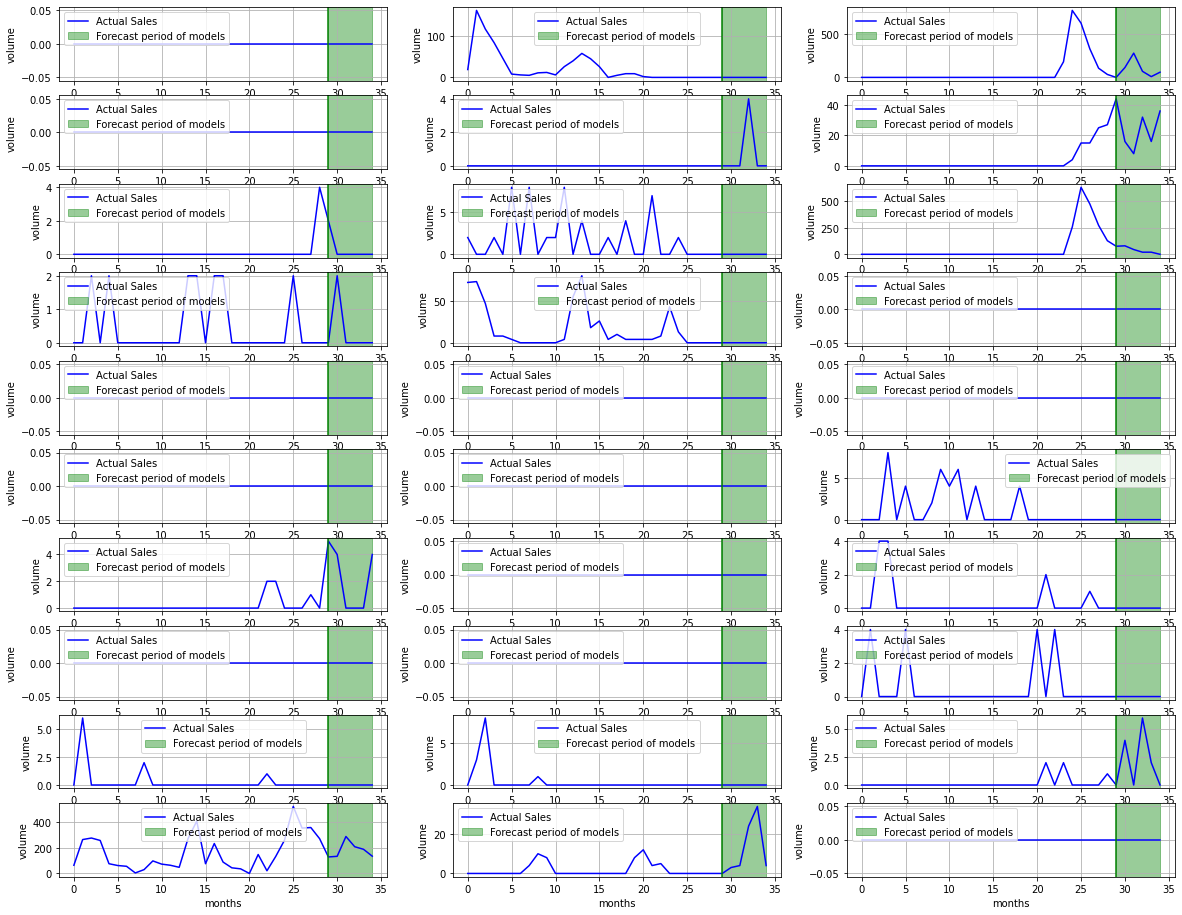

In [71]:
#Function plots 30 random timeseries from data
def MA_calc(data):
    data['MA'] = data['Volume'].rolling(7).mean()
    return data


def plot_ts(data, selection_col, random_selection, mov_ave):
    ts_list = list(data[selection_col].unique())
    if random_selection == True:
        ts_indices = list(np.random.randint(0, len(ts_list), 30))
        ts_list = [ts_list[i] for i in ts_indices]
    fig, axs = plt.subplots(10, 3, figsize=(20, 16))
    x_ax = 0
    y_ax = 0
    for i in range(len(ts_list)):
        ts_choice = data[data[selection_col] == ts_list[i]]
        axs[x_ax, y_ax].plot(ts_choice.time_idx, ts_choice.Volume, c='b', label='Actual Sales')
        if mov_ave == True:
            ts_choice = MA_calc(ts_choice)
            axs[x_ax, y_ax].plot(ts_choice.time_idx, ts_choice.MA, c='m', label='7 period MA')
        axs[x_ax, y_ax].axvspan(xmin=29, xmax=34, color='g', alpha=0.4, label='Forecast period of models')
        axs[x_ax, y_ax].axvline(29, color='g')
        axs[x_ax, y_ax].grid()
        axs[x_ax, y_ax].legend()
        x_ax += 1
        if x_ax == 10:
            y_ax += 1
            x_ax = 0
    for ax in axs.flat:
        ax.set(xlabel='months', ylabel='volume')
    plt.show()


RANDOM=True
MA=False
COL='timeseries'
plot_ts(data_processed, COL, RANDOM, MA)

1.2 Average volume over months

In [72]:
#Get monthly statistics on sales volume over last three years
def vol_stats_calc(data):
    date_idx = data.groupby('time_idx', as_index=False).first()[['Date', 'time_idx']]
    mean_vol = data.groupby('time_idx', as_index=False).mean()[['time_idx', 'Volume']].rename(columns={'Volume':'mean volume'})
    std_vol = data.groupby('time_idx', as_index=False).std()[['time_idx', 'Volume']].rename(columns={'Volume':'std volume'})
    sum_vol = data.groupby('time_idx', as_index=False).sum()[['time_idx', 'Volume']]
    vol_stats_1 = pd.merge(mean_vol, std_vol, how='left', on=['time_idx'])
    vol_stats_2 = pd.merge(vol_stats_1, sum_vol, how='left', on=['time_idx'])
    vol_stats_3 = pd.merge(vol_stats_2, date_idx, how='left', on=['time_idx'])
    print(vol_stats_3.shape)
    print(vol_stats_3.columns.values)
    return vol_stats_3


vol_stats = vol_stats_calc(data_processed)

(35, 5)
['time_idx' 'mean volume' 'std volume' 'Volume' 'Date']


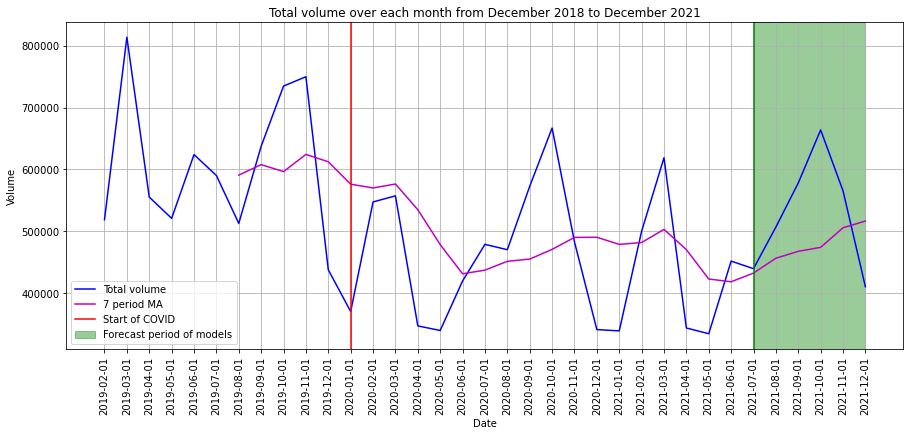

In [73]:
def plot_stats(data):
    data = MA_calc(data)
    data['Date'] = data['Date'].astype(str)
    plt.figure(figsize=(15, 6))
    plt.title('Total volume over each month from December 2018 to December 2021')
    plt.grid()
    plt.plot(data['time_idx'], data['Volume'], c='b', label='Total volume')
    plt.plot(data['time_idx'], data['MA'], c='m', label='7 period MA')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.xticks(ticks=data['time_idx'], labels=data['Date'], rotation='vertical')
    plt.axvspan(xmin=29, xmax=34, color='g', alpha=0.4, label='Forecast period of models')
    plt.axvline(29, color='g')
    plt.axvline(11, color='r', label='Start of COVID')
    plt.legend()
    plt.show()


plot_stats(vol_stats)

1.3 Plot for total volume in each plant

(1015, 7)


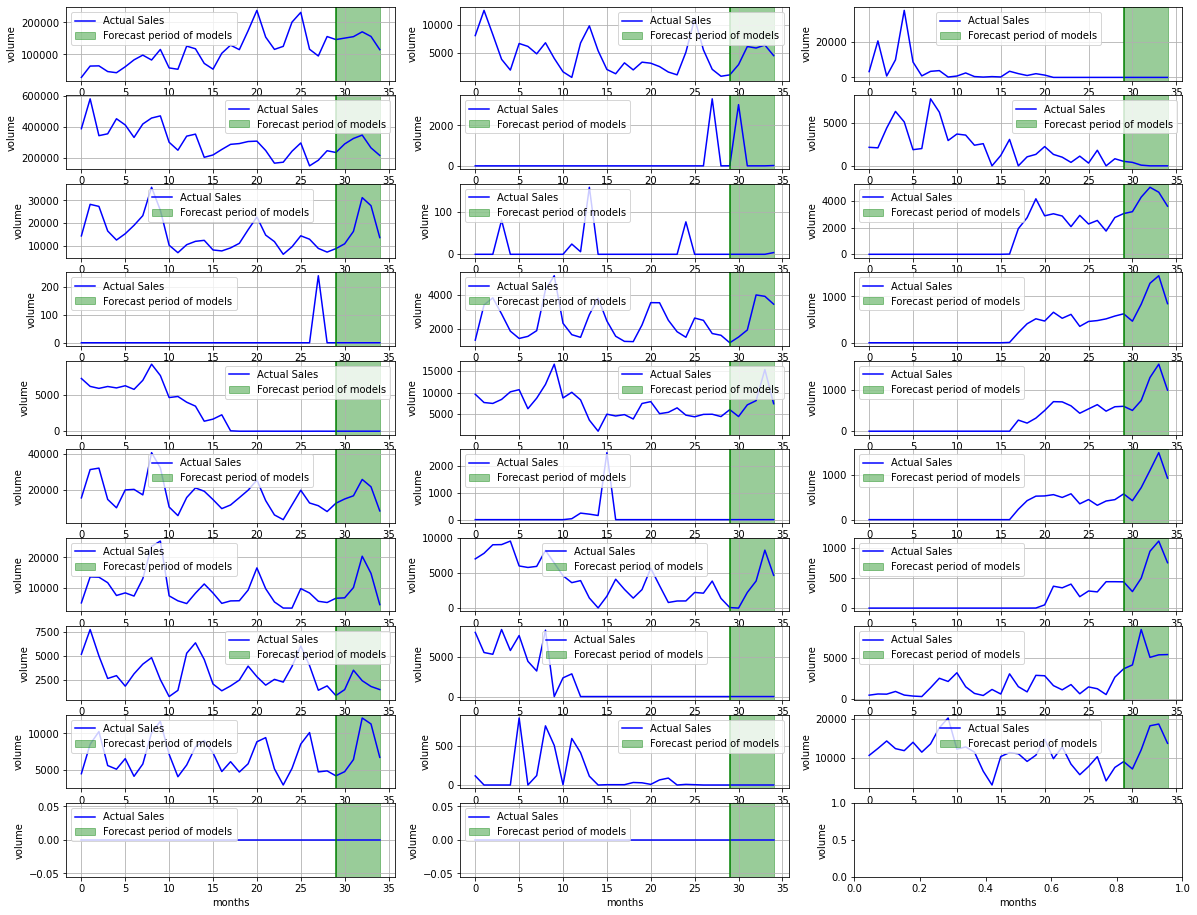

In [74]:
def group_plantIDs(data):
    plant_grouping = data.groupby(['time_idx', 'PlantID'], as_index=False).sum()
    print(plant_grouping.shape)
    return plant_grouping


plant_grouping = group_plantIDs(data_processed)
RANDOM=False
MA=False
COL='PlantID'
plot_ts(plant_grouping, COL, RANDOM, MA)

**2. Perform Dicky Fuller test on total volume over each month to see if it is stationary**

Null hypothesis is that data is non stationary. 
If P-value is less than 0.05 then we can reject the null hypothesis (Data is stationary).
If P-value is more than 0.05 then we cannot reject the null hypothesis (Data is non-stationary).

In [75]:
def p_value_calc(data, after_covid, selected_col):
    if after_covid == True:
        info = adfuller(data[selected_col].iloc[11:])
    else:
        info = adfuller(data[selected_col])
    if info[1] > 0.05:
        print('p-value =', round(info[1], 5), '> 0.05 therefore cannot reject null hypothesis and data is considered non-stationary')
    else:
        print('p-value =', round(info[1], 5), '< 0.05 therefore can reject null hypothesis and data is considered stationary')


COV=False
COL = 'Volume'
p_value_calc(vol_stats, COV, COL)

p-value = 0.22274 > 0.05 therefore cannot reject null hypothesis and data is considered non-stationary


In [76]:
print(vol_stats.columns.values)

['time_idx' 'mean volume' 'std volume' 'Volume' 'Date' 'MA']


**3. Decompose timeseries into trend, season and residuals**

3.1 Use statsmodel module for automatic decompositon

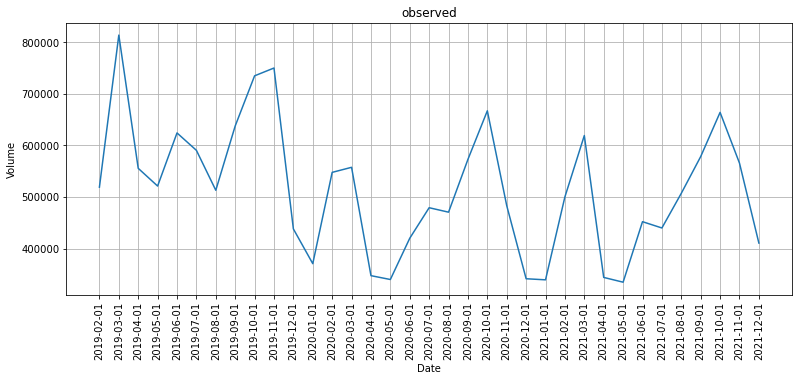

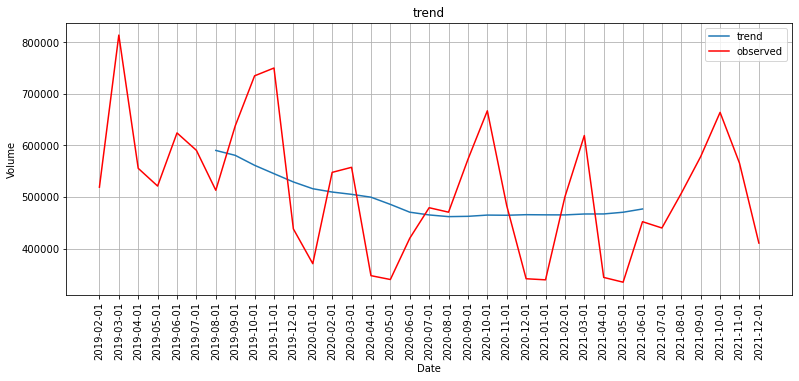

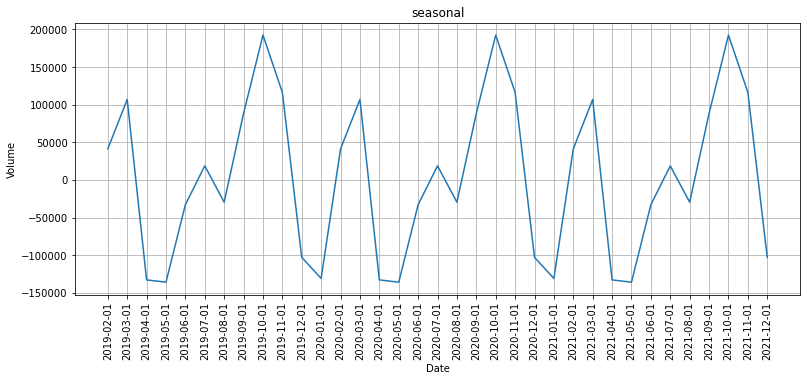

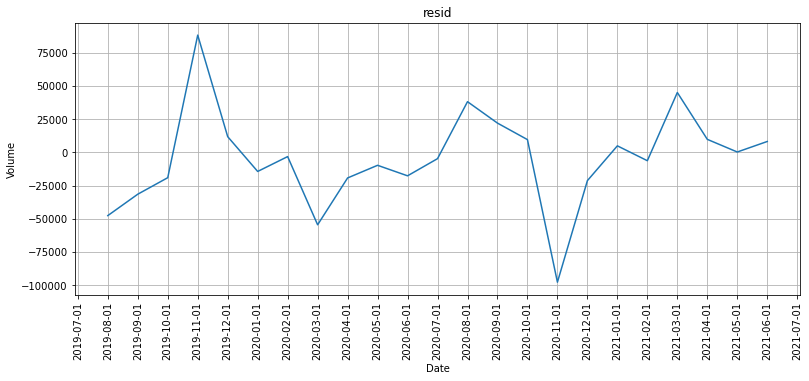

In [77]:
def automatic_decomposition(data, period):
    decomposition_list = ['observed', 'trend', 'seasonal', 'resid']
    decomposition = seasonal_decompose(vol_stats[['Volume']], model='additative', period=period)
    data[decomposition_list[0]] = decomposition.observed
    data[decomposition_list[1]] = decomposition.trend
    data[decomposition_list[2]] = decomposition.seasonal
    data[decomposition_list[3]] = decomposition.resid
    return data


def decomposition_plots(data, cols):
    for col in cols:
        plt.figure(figsize=(13, 5))
        plt.grid()
        plt.title(col)
        if col == 'trend':
            plt.plot(data['Date'], data[col], label='trend')
            plt.plot(data['Date'], data['observed'], c='r', label='observed')
            plt.legend()
        else:
            plt.plot(data['Date'], data[col])
        plt.xticks(rotation='vertical')
        plt.ylabel('Volume')
        plt.xlabel('Date')
        plt.show()


PERIOD=12
vol_stats_2 = automatic_decomposition(vol_stats, PERIOD)
COLS = ['observed', 'trend', 'seasonal', 'resid']
decomposition_plots(vol_stats_2, COLS)

**4. Use transform data to make stationary**

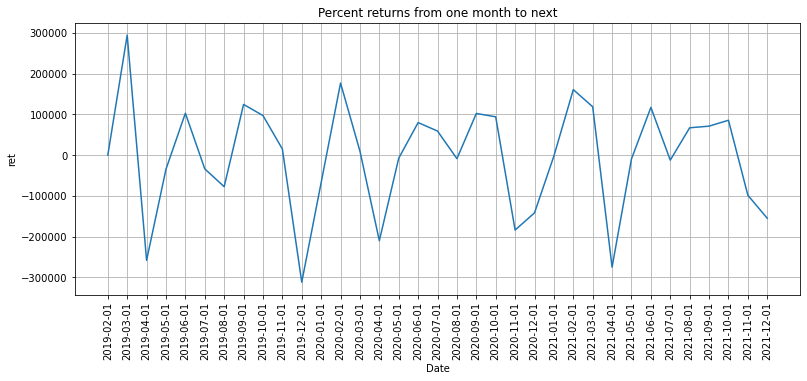

p-value = 0.03115 < 0.05 therefore can reject null hypothesis and data is considered stationary


In [78]:
def ret_calc(data, trans_from, trans_to):
    data[trans_to] = data[trans_from] - data[trans_from].shift(1)
    data[trans_to] = data[trans_to].fillna(0)
    plt.figure(figsize=(13, 5))
    plt.title('Percent returns from one month to next')
    plt.plot(data['Date'], data[trans_to])
    plt.xlabel('Date')
    plt.ylabel(trans_to)
    plt.grid()
    plt.xticks(rotation='vertical')
    plt.show()
    COV=False
    COL = trans_to
    p_value_calc(vol_stats, COV, COL)
    return data


TRANSFORM_COL = 'Volume'
TRANSFORMED_COL = 'ret'
vol_stats_3 = ret_calc(vol_stats_2, TRANSFORM_COL, TRANSFORMED_COL)

Data is stationary after first order differencing. Therefore we do not have to do second order differencing. The d value input into the ARIMA model with be 1. This means the raw data is differenced only once before predictions.

**5. Autocorrelation**

Autocorrelation is a simple method to determine how much one timestep is related to future timesteps. This is acheived by shifting a timeseries one into the future iteratively and finding the correlation coefficient between the origonal timeseries and the shifted timeseries. This is essentially the gradient of the best fit line through the two sets of timeseries.

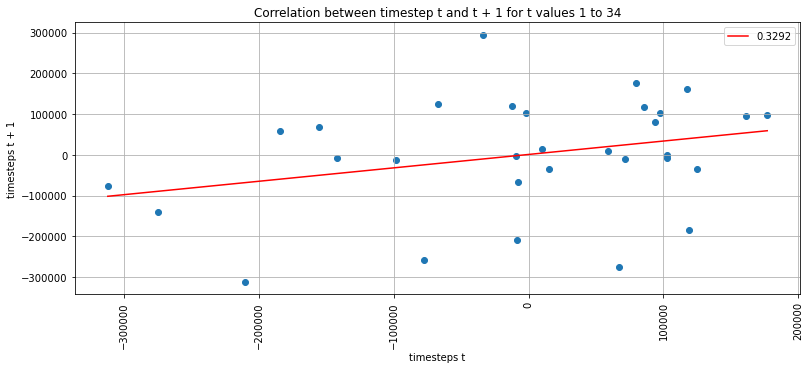

In [113]:
def example_autocorrelation(data, shift):
    line_info = np.polyfit(data['ret'].iloc[shift:], data['ret'].shift(shift).iloc[shift:], 1)
    plt.figure(figsize=(13, 5))
    plt.grid()
    plt.title('Correlation between timestep t and t + 1 for t values 1 to 34')
    plt.xlabel('timesteps t')
    plt.ylabel('timesteps t + 1')
    plt.scatter(data['ret'].iloc[shift:], data['ret'].shift(shift).iloc[shift:])
    x = np.arange(min(data['ret'].iloc[shift:]), max(data['ret'].iloc[shift:]), 10)
    plt.plot(x, (line_info[1] + (line_info[0] * x)), c='r', label=round(line_info[0], 4))
    plt.xticks(rotation='vertical')
    plt.legend()
    plt.show()


SHIFT = 4
example_autocorrelation(vol_stats_3, SHIFT)


[1.0, -0.0598757052641066, -0.5716638891836018, -0.06419290987778635, 0.2974049618058993, -0.008403805388001387, -0.3099491619266058, 0.08855844002408261, 0.46915094879106944, -0.38753004810208885, -0.5022313749380273, 0.3092013480923124, 0.7089172505650706, -0.09044459492134227, -0.624175538109146, -0.02049806696142207, 0.48739740218227556, -0.18420877364817972, -0.2578344176204276, 0.21386655818877223, 0.15166165515287616, -0.20426762934424889, -0.4845900572258424, 0.3492037013411754, 0.7747110694494129, -0.5288801888868755, -0.3535067445692475, 0.24870407855982177, 0.007663177681045401, -0.06481964306633743, -0.1444583016990484, 0.6807840028395459, 0.18775333086968288]


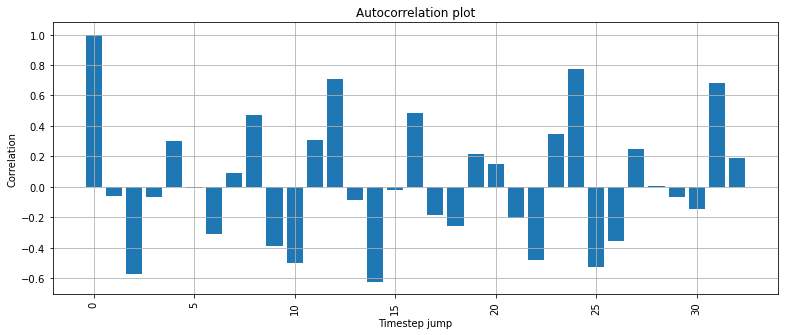

In [118]:
def autocorrelation_calc(data, selected_col, num_diffs):
    correlations = []
    for i in range(num_diffs):
        correlations.append(np.corrcoef(data[selected_col].iloc[i:], data[selected_col].shift(i).iloc[i:])[0, 1])
    plt.figure(figsize=(13, 5))
    plt.grid()
    plt.title('Autocorrelation plot')
    plt.xlabel('Timestep jump')
    plt.ylabel('Correlation')
    plt.bar(range(len(correlations)), correlations)
    plt.xticks(rotation='vertical')
    print(correlations)
    plt.show()


COLS = 'ret'
DIFFS = 33
autocorrelation_calc(vol_stats_3, COLS, DIFFS)

Consistent correlation pattern with positive correlation every four months. After 1 timestep the correlation drops off completely so the p value of the ARIMA model should be 1. The p value in the ARIMA model is known as the lag order and tells the model how far back to look when forecasting future moves.